https://towardsdatascience.com/can-neural-networks-really-learn-any-function-65e106617fc6

In [1]:
import torch
from torch import nn
import torch.utils.data as Data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np
import random

**ReLU**

input data

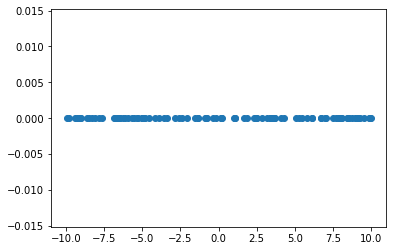

In [2]:
x = []
for _ in range(100): x.append(random.uniform(-10, 10))
plt.scatter(x,np.zeros(100))

Apply ReLu and visualize the function

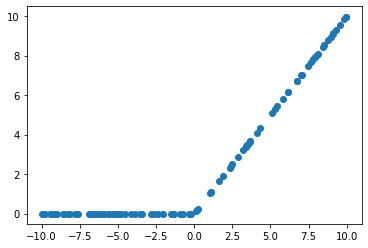

In [3]:
relu = nn.ReLU()
output = np.array(relu(torch.from_numpy(np.array(x))))
plt.scatter(x,output)

Creating a network using pytorch example: https://towardsdatascience.com/building-neural-network-using-pytorch-84f6e75f9a

# Generate Data

Methods to generate data

In [4]:
#methods to generate data
def cubic(x):
    return x**3 + x**2 - x - 1

def quadratic(x):
    return x**2 + 2*x - 2

def get_data(start,end,step_size,f):
    X = np.arange(start, end, step_size)
    X.shape = (len(X),1)
    y = np.array([f(X[i]) for i in range(len(X))])
    y.shape = (len(y),1)
    return X,y

#normalize data
def normalize_vector(X):
    return np.array(X / np.linalg.norm(X))

# Neural networks as  universal approximators

Methods used in this section, to create, train and evaluate pytorch neural networks

In [5]:
use_gpu = torch.cuda.is_available()

def train(net, trainloader, epochs, lr):
    net = net.double()
      
    #loss function / error function
    criterion = torch.nn.MSELoss()
    
    #optimizer algorithm
    #optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    if use_gpu:
        print("Transfering models to GPU(s)")
        net = torch.nn.DataParallel(net).cuda() 
        criterion = criterion.cuda()

    losses = []
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda(non_blocking=True))
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            inputs = inputs.double()
            labels = labels.double()
                
            # zero the parameter gradients
            optimizer.zero_grad()
            
            ##FEED FORWARD
            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = None
            
            ##CALCULATE ERROR
            # for nets that have multiple outputs such as inception
            #if isinstance(outputs, tuple):
                #loss = sum((criterion(o,labels) for o in outputs))
            #else:
            loss = criterion(outputs, labels)
            
            ##BACK FORWARD
            ##computes gradients
            #propagates error back
            loss.backward()
            
            #SGD: otimizer
            #UPDATES THE WEIGTHS USING THE GRADIENTS
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 5 == 4:
                avg_loss = running_loss / 5
                losses.append([epoch,i,avg_loss])
            #    print('[%d, %5d] error: %.3f' %
            #          (epoch + 1, i + 1, avg_loss))
            #    running_loss = 0.0
            
    
    print('Finished Training')
    return losses

def create_nn(hidden_size):
    model = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
    return model

def evaluate(stats, y_test, y_pred, learning_rate,epochs, neurons, function_type):
    #https://gist.github.com/BenjaminPhillips22/4f72801dc8b352ac1545caa32f61effc

    fig = plt.figure(figsize=(20,8))
    
    #plot MSE vs epochs
    stats = np.array(stats)
    ax1 = fig.add_subplot("121")
    ax1.plot(stats[:,0],stats[:,2])
    ax1.title.set_text('MSE vs Epochs')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('MSE')
    
    mse = mean_squared_error(y_test, y_pred.detach().numpy())
    r2 = r2_score(y_test, y_pred.detach().numpy())
        
    print('Neural Network Evaluation: \nMSE: {}; R2: {}'.format(mse, r2))

    #plot y_pred
    ax2 = fig.add_subplot("122")
    ax2.scatter(X_test, y_pred.detach().numpy())
        
    ax2.title.set_text('NN prediction')
    ax2.set_xlabel('data')
    ax2.set_ylabel('target')
    
    if function_type == 'quadratic':
        ax2.text(0.05,0.01 , 'lr: {}'.format(learning_rate), fontdict={'size': 20, 'color':  'red'})
        ax2.text(0.05,0.005 , 'epocs: {}'.format(epochs), fontdict={'size': 20, 'color':  'red'})
        ax2.text(0.05,0.0005 , 'neurons: {}'.format(neurons), fontdict={'size': 20, 'color':  'red'})
    else:
        ax2.text(0.05,-0.025 , 'lr: {}'.format(learning_rate), fontdict={'size': 20, 'color':  'red'})
        ax2.text(0.05,-0.050 , 'epocs: {}'.format(epochs), fontdict={'size': 20, 'color':  'red'})
        ax2.text(0.05,-0.01 , 'neurons: {}'.format(neurons), fontdict={'size': 20, 'color':  'red'})
    return mse, r2, fig

## Quadratic function

Our quadratic function is given by

\begin{equation*}
x^2 + 2x - 2
\end{equation*}

Generate data

dataset size: 400


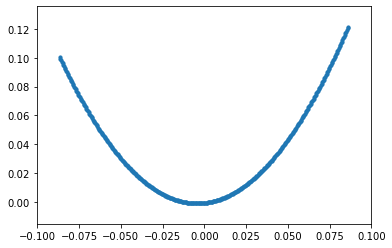

In [6]:
#generate data
X, y = get_data(-20,20,.1,quadratic)
X,y = np.array(X), np.array(y)
#normalize data
X_normalized, y_normalized = normalize_vector(X), normalize_vector(y) 
print('dataset size: {}'.format(len(X)))
#plot the data
plt.scatter(X_normalized,y_normalized, s = 10)

Load the data to pytorch format

In [7]:
batch_size = 30

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.33, random_state=42)
print('train size: {}; test_size: {}'.format(len(X_train), len(X_test)))

torch_dataset = Data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
trainloader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=batch_size, 
    shuffle=True)

train size: 268; test_size: 132


-----------------
Transfering models to GPU(s)
Finished Training
Neural Network Evaluation: 
MSE: 7.434439356467006e-05; R2: 0.9406490729021675
-----------------
Transfering models to GPU(s)
Finished Training
Neural Network Evaluation: 
MSE: 4.348432443687826e-05; R2: 0.9652854123114655
-----------------
Transfering models to GPU(s)
Finished Training
Neural Network Evaluation: 
MSE: 0.0008623413397873382; R2: 0.31157205624866835


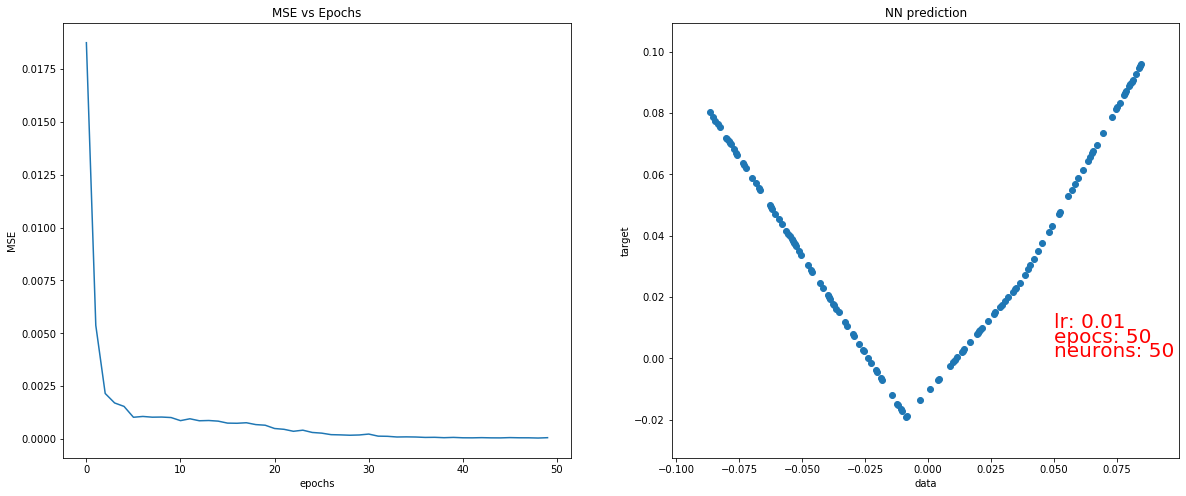

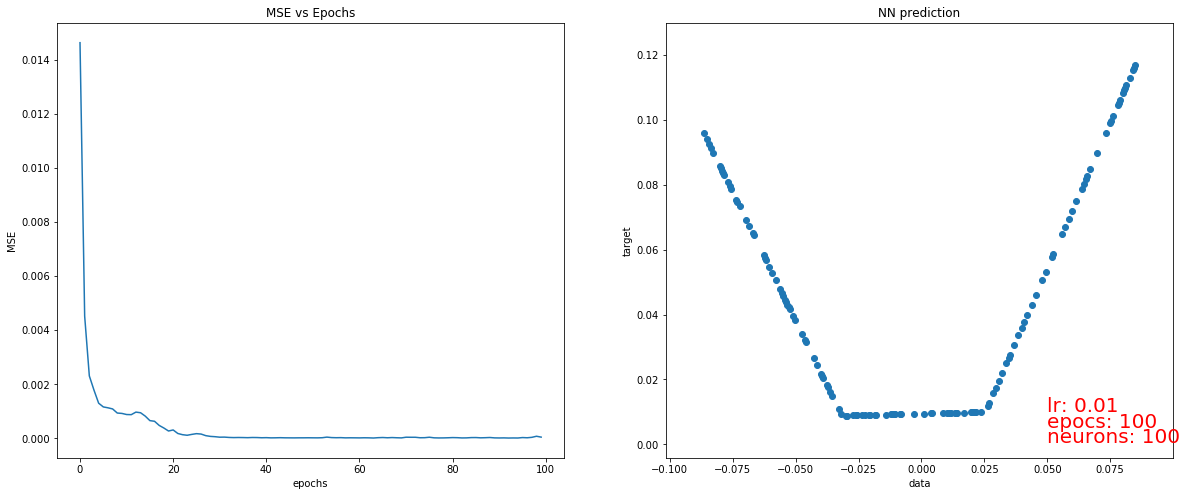

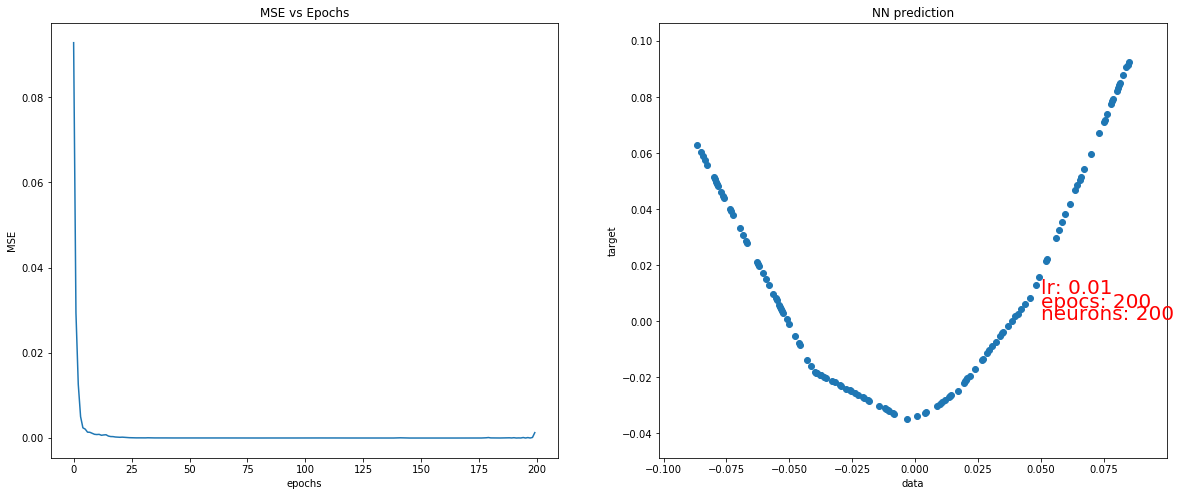

In [8]:
hidden_sizes = [50,100,200]
epochs = [50,100,200]
learning_rates = [0.01,0.01,0.01]

results = []
for i in range(3):
    print('-----------------')

    #create the neural network
    model = create_nn(hidden_sizes[i])
    
    #train the model
    stats = train(model, trainloader, epochs[i], learning_rates[i])
    
    #predict
    if use_gpu: y_pred = model(torch.from_numpy(X_test).cuda()).cpu()
    else: y_pred = model(torch.from_numpy(X_test))
    
    #evaluate
    mse, r2, fig = evaluate(stats,y_test,y_pred, learning_rates[i],epochs[i],hidden_sizes[i],'quadratic')
    
    #save results
    results.append({'model':model,'mse':mse,'r2':r2,'fig':fig})

## Cubic function

Our cubic function is given by

\begin{equation*}
x^3 + x^2 - x - 1
\end{equation*}

dataset size: 400


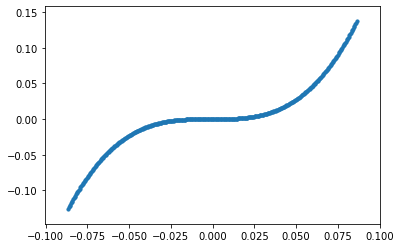

In [9]:
#generate data
X, y = get_data(-20,20,.1,cubic)
X,y = np.array(X), np.array(y)
#normalize data
X_normalized, y_normalized = normalize_vector(X), normalize_vector(y) 
print('dataset size: {}'.format(len(X)))
#plot the data
plt.scatter(X_normalized,y_normalized, s = 10)

Load data to pytorch format

In [10]:
batch_size = 30

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.33, random_state=42)
print('train size: {}; test_size: {}'.format(len(X_train), len(X_test)))

torch_dataset = Data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
trainloader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=batch_size, 
    shuffle=True)

train size: 268; test_size: 132


-----------------
Transfering models to GPU(s)
Finished Training
Neural Network Evaluation: 
MSE: 0.0008016875492641155; R2: 0.7407653508738126
-----------------
Transfering models to GPU(s)
Finished Training
Neural Network Evaluation: 
MSE: 1.004262718586688e-05; R2: 0.9967526040073554


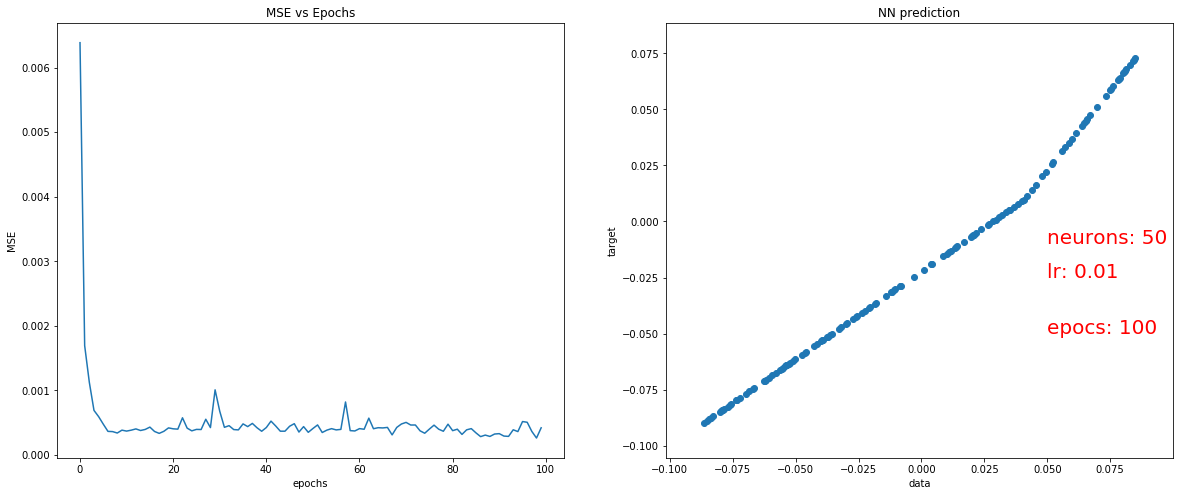

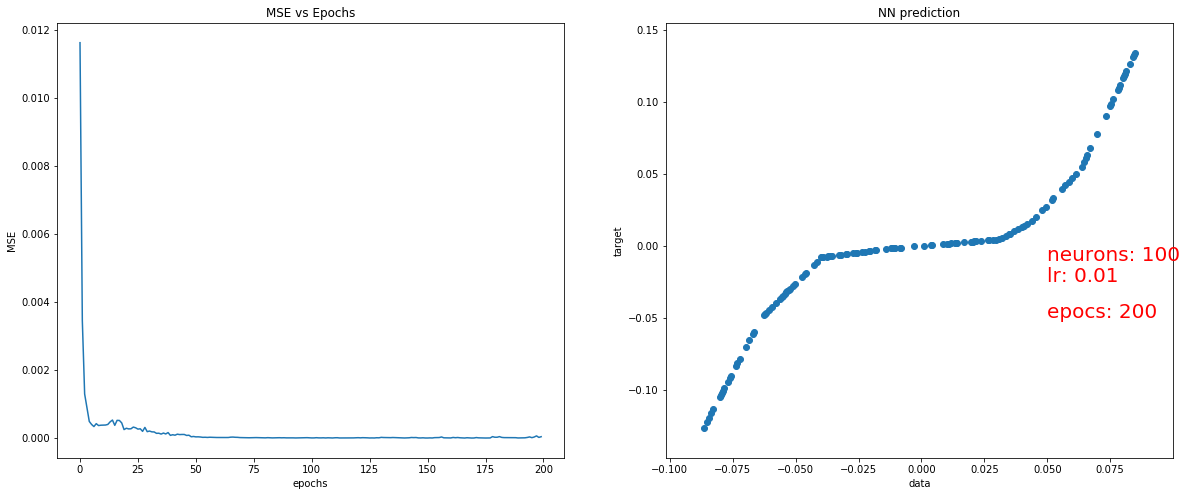

In [11]:
hidden_sizes = [50,100]
epochs = [100,200]
learning_rates = [0.01,0.01]

results = []
for i in range(2):
    print('-----------------')
    #create the neural network
    model = create_nn(hidden_sizes[i])
    
    #train the model
    stats = train(model, trainloader, epochs[i], learning_rates[i])
    
    #predict
    if use_gpu: y_pred = model(torch.from_numpy(X_test).cuda()).cpu()
    else: y_pred = model(torch.from_numpy(X_test))
    
    #evaluate
    mse, r2, fig = evaluate(stats,y_test,y_pred, learning_rates[i],epochs[i],hidden_sizes[i],'cubic')
    
    #save results
    results.append({'model':model,'mse':mse,'r2':r2,'fig':fig})